# General

In [ ]:
using PyPlot
using Base.Iterators: cycle
using JLD
using Distributions
using StatsBase
using JuMP, MathProgBase
using Clp
using Ipopt
using ProfileView
using Gurobi
using Suppressor
using Logging
using JLD2
using FileIO
Logging.configure(level=INFO, filename="output.log");

srand(0)
global_width = 3

function play_sound()
    if is_apple()
        run(`say "your program has finished"`)
    end
end

function my_show()
    if is_apple()
        show()
    end
end

function pipage_round_list(x)
    function pipage_round(x)
        y = copy(x)
        T = []
        for i in 1:length(y)
            if 0 < y[i] < 1
                push!(T, i)
            end
        end
    
        try
            while length(T) > 0
    
                i, j = T[1], T[2]
                if y[i] + y[j] < 1
                    p = y[j] / (y[i] + y[j])
                    if rand() < p
                        y[j] += y[i]
                        y[i] = 0.
                        deleteat!(T, 1)
                    else
                        y[i] += y[j]
                        y[j] = 0.
                        deleteat!(T, 2)
                    end
                else
                    p = (1. - y[i]) / (2. - y[i] - y[j])
                    if rand() < p
                        y[i] += y[j] - 1.
                        y[j] = 1.
                        deleteat!(T, 2)
                        if y[i] == 0.
                            deleteat!(T, 1)
                        end
                    else
                        y[j] += y[i] - 1.
                        y[i] = 1.
                        deleteat!(T, 1)
                        if y[j] == 0.
                            deleteat!(T, 1)
                        end
                    end
                end
            end
        catch
            return y
        end
        return y
    end

    function regularize_answer(ans)
        pp = pipage_round(ans)
        pp[pp .< 1] = 0.
        return pp
    end
    px = regularize_answer(x)
    v = [i for i in 1:length(x) if px[i] != 0]
    return v
end

function uniform_sphere(dim)
	res = randn(dim)
	return res / norm(res)
end

@inline function lin_prog(w, problem)
    lb = ub = A = b = nothing
    sense = '<'
    if length(problem) == 4
        lb, ub, A, b = problem
    else
        lb, ub, A, b, sense = problem
    end
    sol = linprog(-w, A, sense, vec(b), lb, ub, ClpSolver())
    return sol.sol
# 	n = size(A)[2]
# # 	m = Model(solver=ClpSolver())
#     m = Model(solver=GurobiSolver(OutputFlag=0))
#     @variable(m, lb <= x[1:n] <= ub)
#     if sense == '<'
#         @constraint(m, A * x .<= b)
#     else
#         @constraint(m, A * x .== b)
#     end
# 	@objective(m, Max, dot(w, x))
# 	status = solve(m)
# 	return getvalue(x), getobjectivevalue(m)
end

function fw_zero(f, d, T, B, problem; 
    delta=0.001, s=3, f_discrete = nothing, convex_step = nothing)
    x = zeros(d)
    f_eval = x-> (f_discrete == nothing? f(x) : f_discrete(pipage_round_list(x)));
    f_list = zeros(T+1)
    f_list[1] = f_eval(x + delta)
    gbar = zeros(d)
    for t in 1:T
        g = zeros(d)
        for i in 1:B
            u = uniform_sphere(d)            
            g += d/(2*delta) * (f(delta + x + delta*u) - f(delta + x - delta*u)) * u
        end
        g = g/B
        gbar = (1 - 2/(t + s)^(2/3)) * gbar + 2/(t + s)^(2/3) * g
        if convex_step == nothing
            v = lin_prog(gbar, problem)
            x += v / T
        else
            v = lin_prog(-gbar, problem)
            x += convex_step(t) * (v - x)
        end
        f_list[t+1] = f_eval(x + delta)
    end
    return f_list
end

function fw(f, d, T, gradient, problem; 
    f_discrete = nothing, variance_reduction = false, s = 3, convex_step = nothing)
    x = zeros(d);
    f_eval = x-> (f_discrete == nothing? f(x) : f_discrete(pipage_round_list(x)));
    f_list = zeros(T+1)
    f_list[1] = f_eval(x)
    gbar = 0
    for t in 1:T
        if variance_reduction
            gbar = (1 - 2/(t + s)^(2/3)) * gbar + 2/(t + s)^(2/3) * gradient(x)
        else
            gbar = gradient(x)
        end
        if convex_step == nothing
            v = lin_prog(gbar, problem)
            x += v / T
        else
            v = lin_prog(-gbar, problem)
            x += convex_step(t) * (v - x)
        end
        f_list[t+1] = f_eval(x)
    end
    return f_list
end

function gradient_ascent(f, d, T, projection, gradient; 
    delta=0.001, L=1, sigma=1, R=5, f_discrete = nothing, convex_step = nothing, x0 = zeros(d))
    x = projection(x0)
    f_eval = x-> (f_discrete == nothing? f(x) : f_discrete(pipage_round_list(x)));
    f_list = zeros(T+1)
    f_list[1] = f_eval(x)
    for t in 1:T
        g = gradient(x)
        if convex_step == nothing
#             @time x + (1/(L + sigma/R*sqrt(t)))*g
            x = projection(x + (1/(L + sigma/R*sqrt(t)))*g)
        else
            x = projection(x + convex_step(t) * g)
        end
        f_list[t + 1] = f_eval(x)
    end
    return f_list
end

function gradient_ascent_zero(f, d, T, B, projection; 
    delta=0.001, L=1, sigma=1, R=5, f_discrete = nothing, convex_step = nothing) 
    x = projection(zeros(d) + delta)
    f_eval = x-> (f_discrete == nothing? f(x) : f_discrete(pipage_round_list(x)));
    f_list = zeros(T+1)
    f_list[1] = f_eval(x)
    for t in 1:T 
        g = 0
        for i in 1:B
            u = uniform_sphere(d)
            g += d/(2*delta) * (f(x + delta*u) - f(x - delta*u)) * u
        end
        g /= B
        if convex_step == nothing
#             @time x + (1/(L + sigma/R*sqrt(t)))*g
            x = projection(x + (1/(L + sigma/R*sqrt(t)))*g)
        else
            x = projection(x + convex_step(t) * g)
        end
        f_list[t + 1] = f_eval(x)
    end
    return f_list
#     if random_index
#         sampled_f_list = zeros(T+1)
#         for t in 1:(T+1)
#             sampled_f_list[t] = f_list[rand(1:t)]
#         end
#         return sampled_f_list
#     else
#         return f_list
#     end
end
            
# function gradient_ascent_zero(f, d, T, B, projection; 
#     delta=0.001, L=1, sigma=1, R=5, f_discrete = nothing, convex_step = nothing) 
#     x = projection(zeros(d))
#     f_eval = x-> (f_discrete == nothing? f(x) : f_discrete(pipage_round_list(x)));
#     f_list = zeros(T+1)
#     f_list[1] = f_eval(x)
#     for t in 1:T
#         g = 0
#         for i in 1:B
#             u = uniform_sphere(d)
#             g += d/(2*delta) * (f(x + delta*u) - f(x - delta*u)) * u
#         end
#         g /= B
#         if convex_step == nothing
#             x = projection(x + (1/(L + sigma/R*sqrt(t)))*g)
#         else
#             x = projection(x + convex_step(t) * g)
#         end
#         f_list[t + 1] = f_eval(x)
#     end
#     return f_list
# end

function generate_projection_function(A, b; lb = 0, ub = 1, sense = '<')
    n = size(A)[2]
    function projection(x0)
#         sol = quadprog(-x0, eye(n), A, sense, b, lb, ub, IpoptSolver(print_level=0))
        @suppress begin
            sol = quadprog(-x0, eye(n), A, sense, b, lb, ub, GurobiSolver(OutputFlag=0))
            if sol.status == :Optimal
                return sol.sol
            end
        end
        error(string("No solution was found.", x0))
    end
    return projection
end

In [3]:
using SubmodularUtilities

In [38]:
PyPlot.matplotlib[:rc]("pdf", fonttype=42) #, use14corefonts=true)
PyPlot.matplotlib[:rc]("ps", fonttype=42) #, useafm=true)
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", size=26)

# NQP

In [130]:
dim_x = 100
H = -10 * abs.(randn(dim_x, dim_x))

A = cat([1, 2], ones(1, 30), ones(1, 30), ones(1, 40));
b = [20., 20., 20.];

T = 30
B = 1
delta = 0.01
problem_fwzero = [0, 1-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0, 1, A, b]
shrunk_projection = generate_projection_function(A, b, lb=delta, ub=1-delta)
projection = generate_projection_function(A, b)
function f_nqp(x)
    return ((x / 2 - 1)' * H * x)
end
function gradient_nqp(x)
    return vec((H + H') / 2 * x - sum(H',2))
end

gradient_nqp (generic function with 1 method)

In [131]:
list_fwzero = zeros(T + 1)
list_fw = zeros(T + 1)
list_ga = zeros(T + 1)
list_gazero = zeros(T + 1)

info("start NQP ...")
n_experiments = 200
time_fwzero = time_fw = time_ga = time_gazero = 0.
for exp_iter in 1:n_experiments
#     for t in 0:T-1
#         list_fw[t + 1] += fw(f_nqp, dim_x, t, gradient_nqp, problem_fw)[end];
#     end
#     time_fw += @elapsed list_fw[T + 1] += fw(f_nqp, dim_x, T, gradient_nqp, problem_fw)[end];
    time_fw += @elapsed list_fw += fw(f_nqp, dim_x, T, gradient_nqp, problem_fw);
    
#     for t in 0:T-1
#         list_fwzero[t + 1] += fw_zero(f_nqp, dim_x, t, B, problem_fwzero; delta=delta, s=3)[end];
#     end
#     time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(f_nqp, dim_x, T, B, problem_fwzero; delta=delta, s=3)[end];
    time_fwzero += @elapsed list_fwzero += fw_zero(f_nqp, dim_x, T, B, problem_fwzero; delta=delta, s=3);
    
    time_ga += @elapsed list_ga += gradient_ascent(f_nqp, dim_x, T, projection, gradient_nqp; 
        delta=delta, L=5e3, sigma=0, R=1);
    time_gazero += @elapsed list_gazero += gradient_ascent_zero(f_nqp, dim_x, T, B, projection; 
        delta=delta, L=5e3, sigma=2e3, R=1);
end
play_sound()

all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1),
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)];
info(all_time)
info(all_lists)
# iter_lists = [0:length(list_fwzero)-1, 0:length(list_fw)-1, 0:length(list_gazero)-1, 0:length(list_ga)-1]

In [172]:
all_time, all_lists, iter_lists = load("nqp.jld2", "time", "lists", "iter");
labels = ["BCG", "SCG", "ZGA", "GA"];

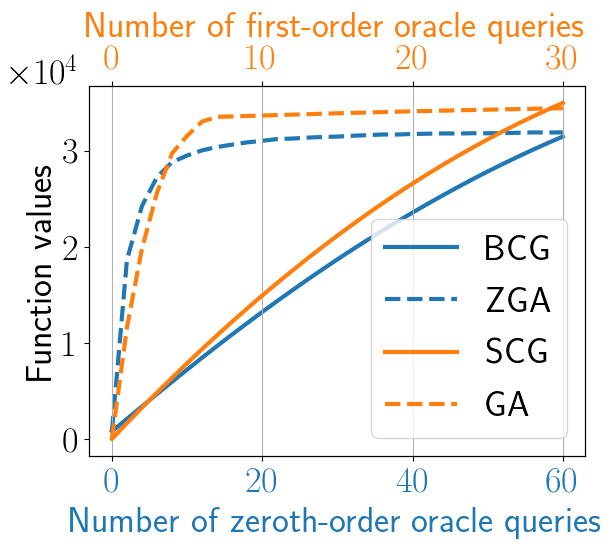

In [150]:
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> !endswith(label, "GA") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("Number of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("Number of first-order oracle queries", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if label == "BCG" || label == "ZGA" || label == "DBG"
        ax1[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
        ax2[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0))
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.16, 0))
ylabel("Function values")
grid()
my_show()
savefig("../pix/nqp_function.pdf", bbox_inches="tight");

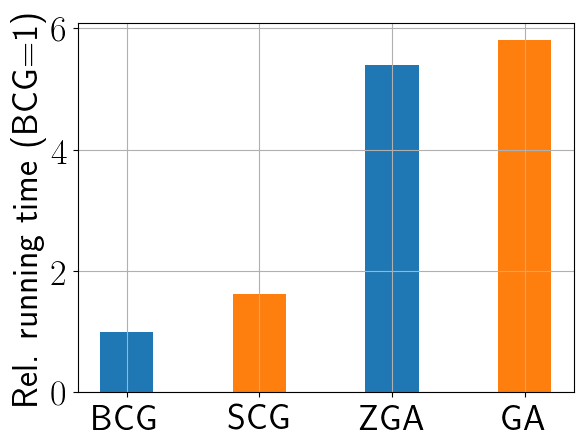

In [173]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (BCG=1)");
savefig("../pix/nqp_time.pdf", bbox_inches="tight");

# Topic Summarization

In [120]:
T = 30
B = 1
delta = 0.005

S = readdlm("reuters.csv", ',')[1:120, :]';
@show n_topics, n_articles = size(S)
dim_x = n_articles;

A = cat([1, 2], ones(1, 40), ones(1, 40), ones(1, 40));

b = [25., 30., 35.];
shrunk_projection = generate_projection_function(A, b, lb=delta, ub=1-delta)
projection = generate_projection_function(A, b)

problem_fwzero = [0., 1-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0., 1., A, b]

prefer = ones(n_topics) / n_topics
function f_topic_summarization(x)
    return dot(prefer, Array([1 - prod([(1 - S[i,j] * x[j]) for j in 1:n_articles]) for i in 1:n_topics]))
end

function gradient_topic_summarization(x)
    grad = zeros(n_articles)
    M = zeros(n_topics)
    for i in 1:n_topics
        M[i] = prod([(1 - S[i,j] * x[j]) for j in 1:n_articles])
    end
    for k in 1:n_articles
        for i in 1:n_topics
            if abs(1 - S[i,k] * x[k]) > 1e-10
                grad[k] += (M[i] / (1 - S[i,k] * x[k])) * S[i, k] * prefer[i]
            else
                grad[k] += prod([(1 - S[i,j] * x[j]) for j in 1:n_articles if j != k]) * S[i, k] * prefer[i]
            end
        end
    end
    return grad
end

(n_topics, n_articles) = size(S) = (10, 120)


gradient_topic_summarization (generic function with 1 method)

In [121]:
list_fwzero = zeros(T + 1);
list_fw = zeros(T + 1);
list_ga = zeros(T + 1);
list_gazero = zeros(T + 1);

n_experiments = 100
time_fwzero = time_fw = time_ga = time_gazero = 0.
info("start topic summarization ...")
for exp_iter in 1:n_experiments
#     time_fwzero += @elapsed list_fwzero += fw_zero(f_topic_summarization, dim_x, T, B, problem_fwzero; delta=delta, s=3);
#     time_fw += @elapsed list_fw += fw(f_topic_summarization, dim_x, T, gradient_topic_summarization, problem_fw);
#     for t in 0:T-1
#         list_fw[t + 1] += fw(f_topic_summarization, dim_x, t, gradient_topic_summarization, problem_fw)[end];
#     end
#     time_fw += @elapsed list_fw[T + 1] += fw(f_topic_summarization, dim_x, T, gradient_topic_summarization, problem_fw)[end];
    time_fw += @elapsed list_fw += fw(f_topic_summarization, dim_x, T, gradient_topic_summarization, problem_fw);
    
#     for t in 0:T-1
#         list_fwzero[t + 1] += fw_zero(f_topic_summarization, dim_x, t, B, problem_fwzero; delta=delta, s=3)[end];
#     end
#     time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(f_topic_summarization, dim_x, T, B, problem_fwzero; delta=delta, s=3)[end];
    time_fwzero += @elapsed list_fwzero += fw_zero(f_topic_summarization, dim_x, T, B, problem_fwzero; delta=delta, s=3);

    time_ga += @elapsed list_ga += gradient_ascent(f_topic_summarization, dim_x, T, projection, gradient_topic_summarization; 
        delta=delta, L=2, sigma=0, R=1);
    time_gazero += @elapsed list_gazero += gradient_ascent_zero(f_topic_summarization, dim_x, T, B, shrunk_projection; 
        delta=delta, L=2, sigma=1, R=1);
end
play_sound();

all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1),
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)];
info(all_time)
info(all_lists)

In [174]:
all_time, all_lists, iter_lists = load("top_sum.jld2", "time", "lists", "iter");
labels = ["BCG", "SCG", "ZGA", "GA"];

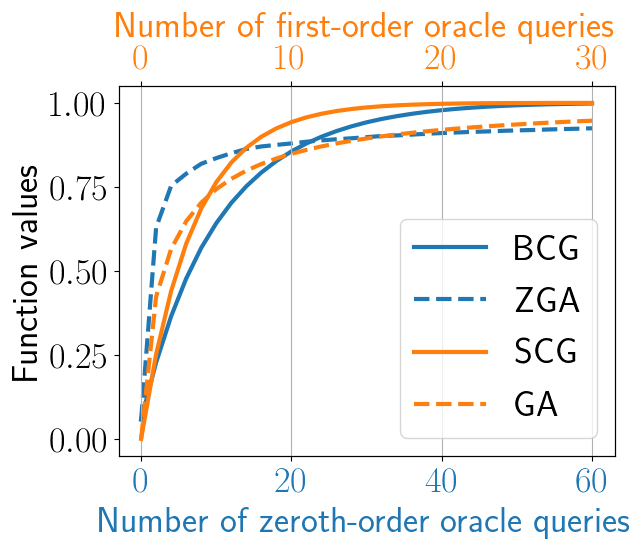

In [155]:
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> !endswith(label, "GA") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("Number of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("Number of first-order oracle queries", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if label == "BCG" || label == "ZGA" || label == "DBG"
        ax1[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
        ax2[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0))
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.16, 0))
ylabel("Function values")
grid()
my_show()
savefig("../pix/topic_function.pdf", bbox_inches="tight");

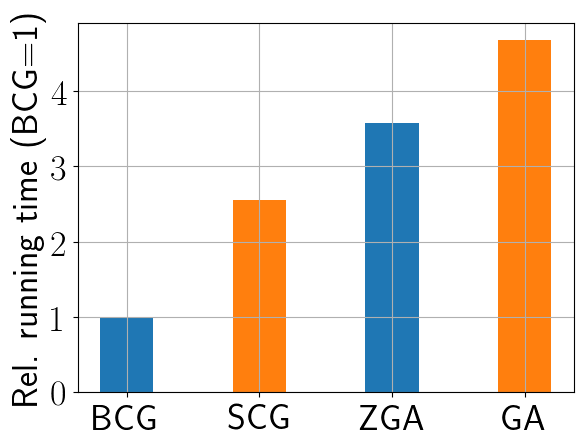

In [175]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (BCG=1)");
savefig("../pix/topic_time.pdf", bbox_inches="tight");

# Active Set Selection

In [100]:
function get_random_gradient_of_multilinear_extension2(f_discrete)
    function stochastic_gradient(x)
        grad = zero(x);
        for i in 1:length(x)
            S = random_round(x);
            grad[i] = f_discrete(vcat(S, i)) - f_discrete(setdiff(S, i));
        end
        return grad
    end
    return stochastic_gradient
end

get_random_gradient_of_multilinear_extension2 (generic function with 1 method)

In [176]:
data = readdlm("parkinsons_updrs.data", ',', skipstart = 1);
dim_x = size(data)[2];
cov_matrix = zeros(dim_x, dim_x);
for i in 1:dim_x
    for j in 1:i
        cov_matrix[i, j] = exp(-norm(data[:, i] - data[:, j])^2 / 0.75^2)
        if j != i
            cov_matrix[j, i] = cov_matrix[i, j]
        end
    end
end

function f_active_set_discrete(S)
    if isempty(S)
        return 0.;
    end
    return 0.5 * log(det(eye(length(S)) + cov_matrix[S, S]))
end

f_active_set_stoch = get_random_evaluation_of_multilinear_extension(f_active_set_discrete);
gradient_active_set_stoch = get_random_gradient_of_multilinear_extension(f_active_set_discrete);

In [102]:
A = cat([1, 2], ones(1, 4), ones(1, 4), ones(1, 4), ones(1, 5), ones(1, 5));
b = [1., 1., 1., 1., 1.] + 0.01;
delta = 0.01;
B = 1;
T = 30;
shrunk_projection = generate_projection_function(A, b, lb=delta, ub=1-delta)
projection = generate_projection_function(A, b)

problem_fwzero = [0, 1-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0, 1, A, b];

In [103]:
list_fwzero = zeros(T + 1);
list_fw = zeros(T + 1);
list_ga = zeros(T + 1);
list_gazero = zeros(T + 1);

n_experiments = 1000
time_fwzero = time_fw = time_ga = time_gazero = 0.
info("start active set selection ...")
for exp_iter in 1:n_experiments
    time_ga += (@elapsed list_ga += gradient_ascent(f_active_set_stoch, dim_x, T, projection, gradient_active_set_stoch; 
        delta=delta, L=10, sigma=1, R=1, f_discrete = f_active_set_discrete));
    time_gazero += (@elapsed list_gazero += gradient_ascent_zero(f_active_set_stoch, dim_x, T, B, shrunk_projection; 
            delta=delta, L=20, sigma=100, R=1, f_discrete = f_active_set_discrete));
    
#     for t in 0:T-1
#         list_fw[t + 1] += fw(f_active_set_stoch, dim_x, t, gradient_active_set_stoch, problem_fw)[end];
#     end
#     time_fw += @elapsed list_fw[T + 1] += fw(f_active_set_stoch, dim_x, T, gradient_active_set_stoch, problem_fw)[end];
    time_fw += @elapsed list_fw += fw(f_active_set_stoch, dim_x, T, gradient_active_set_stoch, problem_fw);
    
#     for t in 0:T-1
#         list_fwzero[t + 1] += fw_zero(f_active_set_stoch, dim_x, t, B, problem_fwzero; delta=delta, s=3)[end];
#     end
#     time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(f_active_set_stoch, dim_x, T, B, problem_fwzero; delta=delta, s=3)[end];
    time_fwzero += @elapsed list_fwzero += fw_zero(f_active_set_stoch, dim_x, T, B, problem_fwzero; delta=delta, s=3);
end
play_sound()

all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1)*2*dim_x,
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)*2*dim_x];
info(all_time, all_lists)

In [167]:
all_time, all_lists, iter_lists = load("act_set.jld2", "time", "lists", "iter");

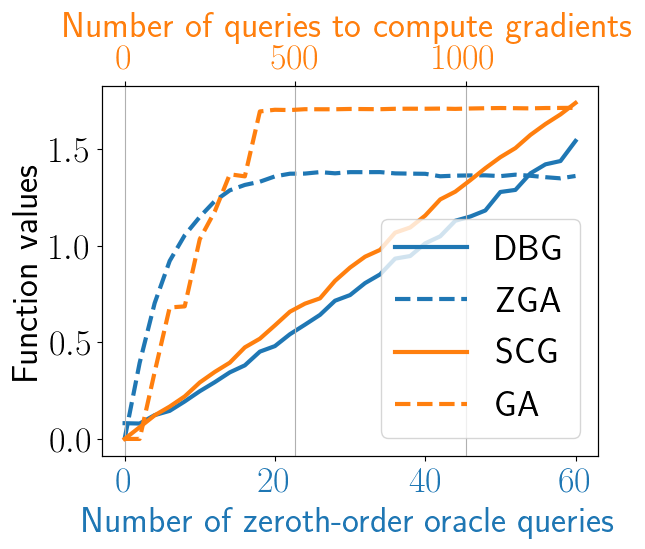

In [158]:
labels = ["DBG", "SCG", "ZGA", "GA"]
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> !endswith(label, "GA") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("Number of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("Number of queries to compute gradients", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if label == "BCG" || label == "ZGA" || label == "DBG"
        ax1[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
        ax2[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0))
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.16, 0))
ylabel("Function values")
grid()
my_show()
savefig("../pix/active_function.pdf", bbox_inches="tight");

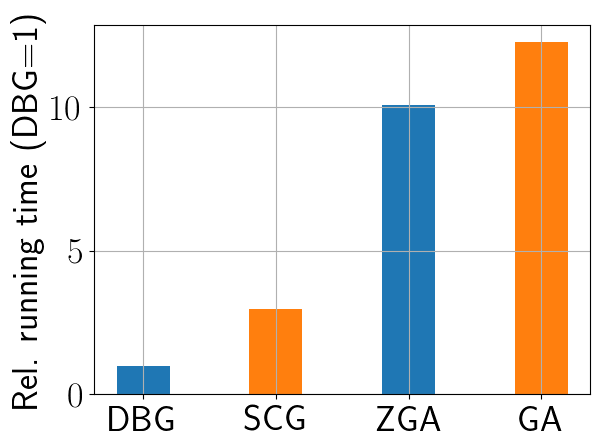

In [168]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (DBG=1)");
savefig("../pix/active_time.pdf", bbox_inches="tight");

# Exemplar-Based Clustering

In [72]:
# using RDatasets;
# iris = dataset("datasets", "iris");
# data = convert(Array, iris[:, 1:4]);

census = readdlm("USCensus500.txt", ',', skipstart = 1);
data = census[1:120, 2:end];

f_exemplar = get_function_exemplar_based_clustering(data);
f_exemplar_stoch = get_random_evaluation_of_multilinear_extension(f_exemplar);
g_exemplar_stoch = get_random_gradient_of_multilinear_extension(f_exemplar);

In [76]:
A = cat([1, 2], ones(1, 30), ones(1, 30), ones(1, 30), ones(1, 30));
b = [10., 10., 10., 10.] .+ 0.01;
delta = 0.01;
B = 1;
T = 30;

shrunk_projection = generate_projection_function(A, b, lb=delta, ub=1-delta)
projection = generate_projection_function(A, b)

problem_fwzero = [0, 1-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0, 1, A, b];

In [100]:
list_fwzero = zeros(T + 1);
list_fw = zeros(T + 1);
list_ga = zeros(T + 1);
list_gazero = zeros(T + 1);

dim_x = size(data)[1];

n_experiments = 2
time_fwzero = time_fw = time_ga = time_gazero = 0.
info("start exemplar-based clustering ...")
info("# of experiments: ", n_experiments)
for exp_iter in 1:n_experiments
    time_ga += @elapsed list_ga += gradient_ascent(f_exemplar_stoch, dim_x, T, projection, g_exemplar_stoch; 
        delta=delta, L=5e4, sigma=5e4, R=1, f_discrete = f_exemplar);
    time_gazero += @elapsed list_gazero += gradient_ascent_zero(f_exemplar_stoch, dim_x, T, B, shrunk_projection; 
            delta=delta, L=5e6, sigma=5e6, R=1, f_discrete = f_exemplar);
#     time_fwzero += @elapsed list_fwzero += fw_zero(f_exemplar_stoch, dim_x, T, B, problem_fwzero; 
#         delta=delta, s=3, f_discrete = f_exemplar);
#     time_fw += @elapsed list_fw += fw(f_exemplar_stoch, dim_x, T, g_exemplar_stoch, problem_fw, 
#         f_discrete = f_exemplar, variance_reduction = true);
    
#     for t in 0:T-1
#         list_fw[t + 1] += fw(f_exemplar_stoch, dim_x, t, g_exemplar_stoch, problem_fw)[end];
#     end
#     time_fw += @elapsed list_fw[T + 1] += fw(f_exemplar_stoch, dim_x, T, g_exemplar_stoch, problem_fw)[end];
    time_fw += @elapsed list_fw += fw(f_exemplar_stoch, dim_x, T, g_exemplar_stoch, problem_fw);
    
#     for t in 0:T-1
#         list_fwzero[t + 1] += fw_zero(f_exemplar_stoch, dim_x, t, B, problem_fwzero; delta=delta, s=3)[end];
#     end
#     time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(f_exemplar_stoch, dim_x, T, B, problem_fwzero; delta=delta, s=3)[end];
    time_fwzero += @elapsed list_fwzero += fw_zero(f_exemplar_stoch, dim_x, T, B, problem_fwzero; delta=delta, s=3);
end
play_sound()

all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1)*2*dim_x,
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)*2*dim_x];
info(all_time, all_lists)

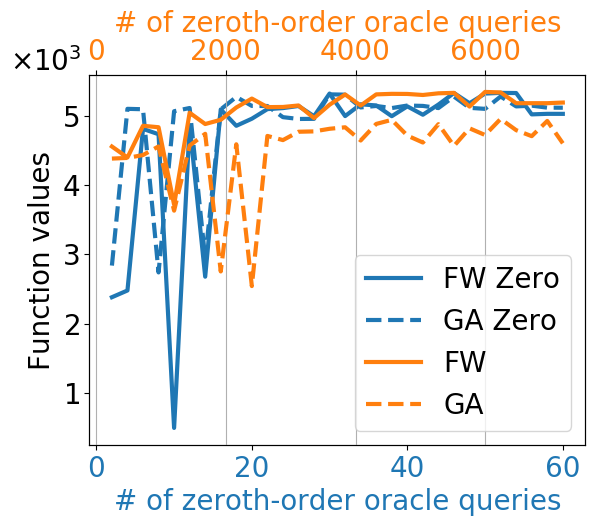

In [101]:
labels = ["FW Zero", "FW", "GA Zero", "GA"]
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> startswith(label, "FW") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("# of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("# of zeroth-order oracle queries", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if endswith(label, "Zero")
        ax1[:plot](iter[2:end], reward[2:end], label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
            ax2[:plot](iter[2:end], reward[2:end], label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0), useMathText=true)
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.16, 0))
ylabel("Function values")
grid()
my_show()
# savefig("../pix/exemplar_function.eps", bbox_inches="tight");

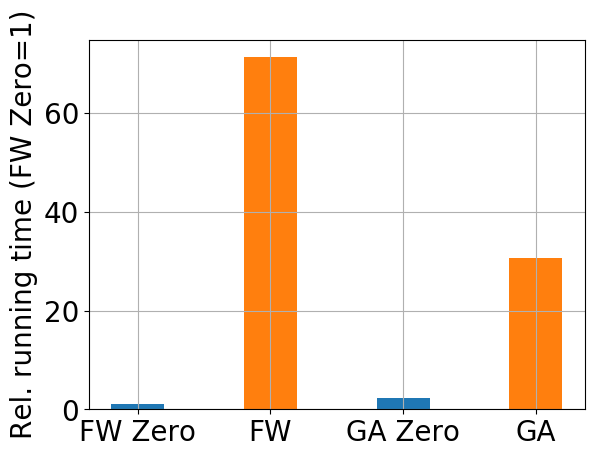

In [80]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (FW Zero=1)")
# savefig("../pix/exemplar_function.eps", bbox_inches="tight");

# Influence Maximization

In [55]:
# using GraphPlot
using LightGraphs

In [56]:
es = readdlm("karate.txt", ' ', Int)
es = es + 1;

In [57]:
N = maximum(es)
for i=1:size(es, 1)
    if es[i,1] > es[i,2]
        es[i,1], es[i,2] = es[i,2], es[i,1]
    end
end
g = Graph(N)
for i=1:size(es,1)
    add_edge!(g, es[i,1], es[i,2])
end

In [58]:
function get_function_coverage(g)
    return S->length(union([neighbors(g, v) for v in S]));
end

f_coverage = get_function_coverage(g);
f_coverage_stoch = get_random_evaluation_of_multilinear_extension(f_coverage);
g_coverage_stoch = get_random_gradient_of_multilinear_extension(f_coverage);

In [59]:
dim_x = nv(g)
A = cat([1, 2], ones(1, 10), ones(1, 14), ones(1, 10));
b = [2., 2., 2.] .+ 0.01;
delta = 0.01;
B = 1;
T = 30;

shrunk_projection = generate_projection_function(A, b, lb=delta, ub=1-delta)
projection = generate_projection_function(A, b)

problem_fwzero = [0, 1-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0, 1, A, b]

list_fwzero = zeros(T + 1);
list_fw = zeros(T + 1);
list_ga = zeros(T + 1);
list_gazero = zeros(T + 1);

n_experiments = 1000
time_fwzero = time_fw = time_ga = time_gazero = 0.
info("start coverage ...")
for exp_iter in 1:n_experiments
    time_ga += @elapsed list_ga += gradient_ascent(f_coverage_stoch, dim_x, T, projection, g_coverage_stoch; 
        delta=delta, L=5e1, sigma=0, R=1, f_discrete = f_coverage);
    time_gazero += @elapsed list_gazero += gradient_ascent_zero(f_coverage_stoch, dim_x, T, B, shrunk_projection; 
            delta=delta, L=5e2, sigma=1e3, R=1, f_discrete = f_coverage);
#     time_fwzero += @elapsed list_fwzero += fw_zero(f_coverage_stoch, dim_x, T, B, problem_fwzero; 
#         delta=delta, s=3, f_discrete = f_coverage);
#     time_fw += @elapsed list_fw += fw(f_coverage_stoch, dim_x, T, g_coverage_stoch, problem_fw, 
#         f_discrete = f_coverage, variance_reduction = true);
    
#     for t in 0:T-1
#         list_fw[t + 1] += fw(f_coverage_stoch, dim_x, t, g_coverage_stoch, problem_fw)[end];
#     end
#     time_fw += @elapsed list_fw[T + 1] += fw(f_coverage_stoch, dim_x, T, g_coverage_stoch, problem_fw)[end];
    time_fw += @elapsed list_fw += fw(f_coverage_stoch, dim_x, T, g_coverage_stoch, problem_fw);
    
#     for t in 0:T-1
#         list_fwzero[t + 1] += fw_zero(f_coverage_stoch, dim_x, t, B, problem_fwzero; delta=delta, s=3)[end];
#     end
#     time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(f_coverage_stoch, dim_x, T, B, problem_fwzero; delta=delta, s=3)[end];
    time_fwzero += @elapsed list_fwzero += fw_zero(f_coverage_stoch, dim_x, T, B, problem_fwzero; delta=delta, s=3);
end
play_sound()

all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1)*2*dim_x, 
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)*2*dim_x];
info(all_time, all_lists)

In [169]:
all_time, all_lists, iter_lists = load("inf_max.jld2", "time", "lists", "iter");

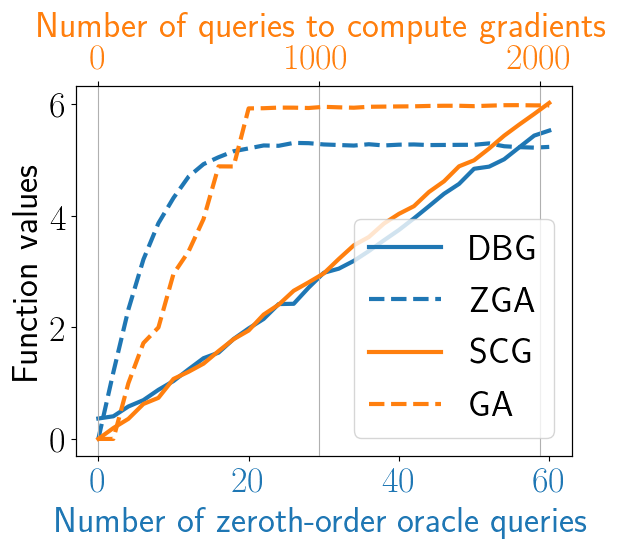

In [161]:
labels = ["DBG", "SCG", "ZGA", "GA"]
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> !endswith(label, "GA") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("Number of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("Number of queries to compute gradients", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if label == "BCG" || label == "ZGA" || label == "DBG"
        ax1[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
        ax2[:plot](iter, reward, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0), useMathText=true)
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.16, 0))
ylabel("Function values")
grid()
my_show()
savefig("../pix/cover_function.pdf", bbox_inches="tight");

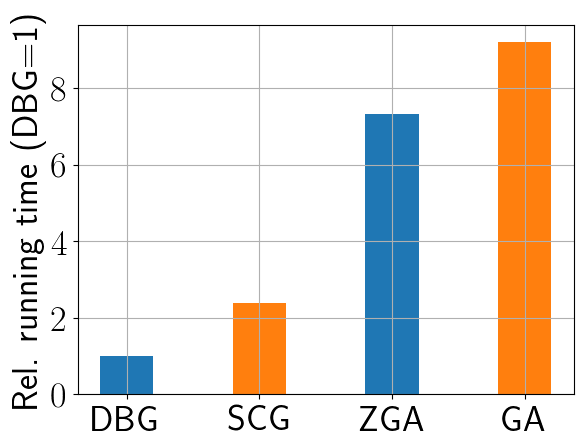

In [170]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (DBG=1)");
savefig("../pix/cover_time.pdf", bbox_inches="tight");

# Logistic Regression

In [ ]:
data = readdlm("~/Projection_Free_Bandit/experiment/spambase.data", ',', Float32);
@show size(data)

size(data) = (4601, 58)


(4601, 58)

In [22]:
data = readdlm("sonar.csv", ',', Float32);

In [ ]:
data = readdlm("~/Datasets/ionosphere.csv", ',', Float32);
@show size(data)

size(data) = (351, 35)


(351, 35)

In [43]:
using RDatasets;
iris = dataset("datasets", "iris");
data = convert(Array, iris[1:100, 1:4]);
data = hcat(data, repeat(0:1, inner=50));

In [50]:
permuted_indices = randperm(size(data)[1])
x = Array{Float32, 2}(data[permuted_indices, 1:end - 1])
y = Array{Int32}(data[permuted_indices, end]);

In [51]:
f_multiclass = beta -> sum([-y[i] * dot(beta, x[i, :]) + log(1 + exp(dot(beta, x[i, :]))) for i in 1:100])
g_multiclass = beta -> ForwardDiff.gradient(f_multiclass, beta) + randn(size(beta)) * length(beta);
# g_multiclass = beta -> sum([x[i, :] * (-y[i]+1-1/(1+exp(dot(beta, x[i, :])))) for i in 1:100]) + randn(size(beta)) * length(beta);
convex_step = t -> 2 / (t+3+2);

In [70]:
@show dim_x = size(x)[2]
A = ones(1, dim_x);
b = [10.];
delta = 0.01;
B = 1;
T = 35;
ub = 1.
gradient_descent_step_size = 5e-3
gradient_descent_zero_step_size = 5e-3

shrunk_projection = projection = generate_projection_function(A, b, lb = 0., ub=ub)

problem_fwzero = [0, ub-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0, ub, A, b]

list_fwzero = zeros(T + 1);
list_fw = zeros(T + 1);
list_ga = zeros(T + 1);
list_gazero = zeros(T + 1);

n_experiments = 10
time_fwzero = time_fw = time_ga = time_gazero = 0.
info("start logistic regression ...")
for exp_iter in 1:n_experiments
    time_ga += @elapsed list_ga += gradient_ascent(f_multiclass, dim_x, T, projection, g_multiclass; 
        delta=delta, convex_step = t -> -gradient_descent_step_size);
    time_gazero += @elapsed list_gazero += gradient_ascent_zero(f_multiclass, dim_x, T, B, shrunk_projection; 
            delta=delta, convex_step = t -> -gradient_descent_zero_step_size);
#     for t in 0:T-1
#         list_fw[t + 1] += fw(f_multiclass, dim_x, t, g_multiclass, problem_fw, convex_step = convex_step, variance_reduction=true)[end];
#     end
#     time_fw += @elapsed list_fw[T + 1] += fw(f_multiclass, dim_x, T, g_multiclass, problem_fw, convex_step = convex_step, variance_reduction=true)[end];
    time_fw += @elapsed list_fw += fw(f_multiclass, dim_x, T, g_multiclass, problem_fw, convex_step = convex_step, variance_reduction=true);
    
#     for t in 0:T-1
#         list_fwzero[t + 1] += fw_zero(f_multiclass, dim_x, t, B, problem_fwzero; delta=delta, s=3, convex_step = convex_step)[end];
#     end
#     time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(f_multiclass, dim_x, T, B, problem_fwzero; delta=delta, s=3, convex_step = convex_step)[end];
    time_fwzero += @elapsed list_fwzero += fw_zero(f_multiclass, dim_x, T, B, problem_fwzero; delta=delta, s=3, convex_step = convex_step);
end
play_sound()

all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1), 
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)];
info(all_time, all_lists)

dim_x = (size(x))[2] = 34


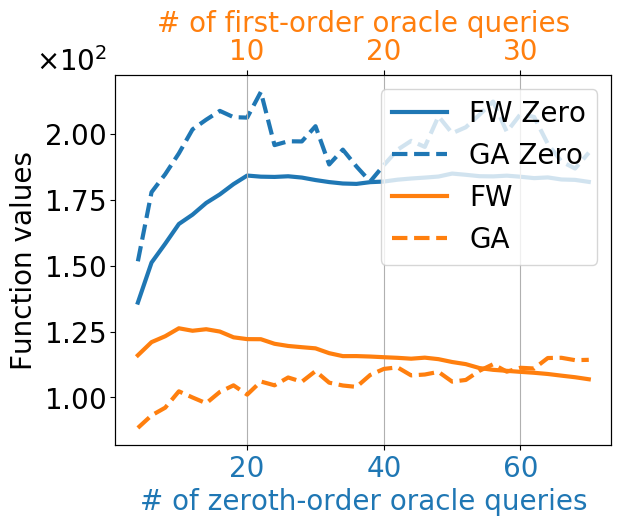

In [71]:
labels = ["FW Zero", "FW", "GA Zero", "GA"]
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> startswith(label, "FW") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("# of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("# of first-order oracle queries", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if endswith(label, "Zero")
        ax1[:plot](iter[3:end], reward[3:end], label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
        ax2[:plot](iter[3:end], reward[3:end], label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0), useMathText=true)
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.16, 0))
ylabel("Function values")
grid()
my_show()
# savefig("../pix/logistic_function.eps", bbox_inches="tight");

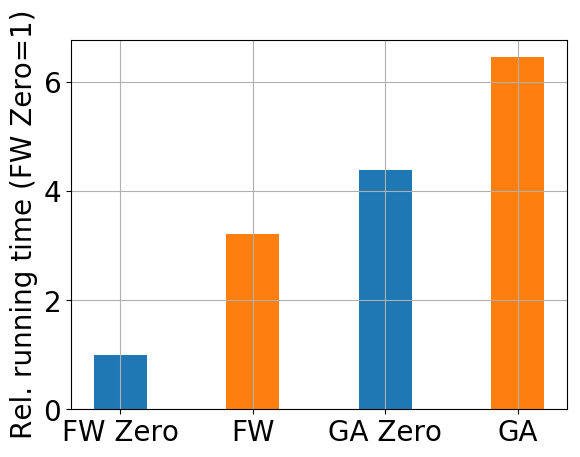

In [69]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (FW Zero=1)");
# savefig("../pix/logistic_time.eps", bbox_inches="tight");

# Regression

In [89]:
dim_x = 30
mu = rand(dim_x) * 40 - 20
f_regression = (x, a) -> dot(exp.(-(x-mu).^2), a)
x = -20:1:20
true_a = normalize!(rand(dim_x), 1)
y = map(x_->f_regression(x_, true_a), x);

In [90]:
loss = a -> sum([(f_regression(x[i], a) - y[i]).^2 for i in 1:length(x)])
g_loss = a-> ForwardDiff.gradient(loss, a)
convex_step = t -> 2 / (t+3+2);

In [91]:
A = ones(1, dim_x);
# A = cat([1, 2], ones(1, 10), ones(1, 10), ones(1, 10));
# b = [5., 5., 5.];
b = [1.]
delta = 0.01;
B = 1;
T = 30;
# ub = 2.
gradient_descent_step_size = 0.05
gradient_descent_zero_step_size = 0.05

shrunk_projection = generate_projection_function(A, b, lb=delta, ub=1-delta)
projection = generate_projection_function(A, b)
# shrunk_projection = projection = generate_projection_function(A, b, lb = 0., ub=ub)

problem_fwzero = [0, 1.-2*delta, A, b-delta*sum(A, 2)]
problem_fw = [0, 1., A, b]

list_fwzero = zeros(T + 1);
list_fw = zeros(T + 1);
list_ga = zeros(T + 1);
list_gazero = zeros(T + 1);

n_experiments = 500
time_fwzero = time_fw = time_ga = time_gazero = 0.
for exp_iter in 1:n_experiments
    time_ga += @elapsed list_ga += gradient_ascent(loss, dim_x, T, projection, g_loss; 
        delta=delta, convex_step = t -> -gradient_descent_step_size, x0 = ones(dim_x) * delta);
    time_gazero += @elapsed list_gazero += gradient_ascent_zero(loss, dim_x, T, B, shrunk_projection; 
            delta=delta, convex_step = t -> -gradient_descent_zero_step_size);
    for t in 0:T-1
        list_fw[t + 1] += fw(loss, dim_x, t, g_loss, problem_fw, convex_step = convex_step, variance_reduction = false)[end];
    end
    time_fw += @elapsed list_fw[T + 1] += fw(loss, dim_x, T, g_loss, problem_fw, convex_step = convex_step, variance_reduction = false)[end];
    
    for t in 0:T-1
        list_fwzero[t + 1] += fw_zero(loss, dim_x, t, B, problem_fwzero; delta=delta, s=3, convex_step = convex_step)[end];
    end
    time_fwzero += @elapsed list_fwzero[T + 1] += fw_zero(loss, dim_x, T, B, problem_fwzero; delta=delta, s=3, convex_step = convex_step)[end];
end
play_sound()

@show all_time  = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments;
@show all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments;
iter_lists = [(0:length(list_fwzero)-1)*2*B, (0:length(list_fw)-1), 
    (0:length(list_gazero)-1)*2*B, (0:length(list_ga)-1)];

all_time = [time_fwzero, time_fw, time_gazero, time_ga] / n_experiments = [0.100538, 0.115896, 0.139807, 0.155109]
all_lists = [list_fwzero, list_fw, list_gazero, list_ga] / n_experiments = Array{Float64,1}[[0.0597203, 0.0937591, 0.099809, 0.103333, 0.0980735, 0.0938041, 0.0877696, 0.0851858, 0.0794633, 0.0758994, 0.0719482, 0.0710318, 0.065506, 0.0637119, 0.0623297, 0.0588212, 0.055826, 0.0537963, 0.0526881, 0.0521881, 0.0490209, 0.0489859, 0.0447829, 0.0464199, 0.0448474, 0.0428806, 0.0410793, 0.0411121, 0.0396865, 0.0383413, 0.0375529], [0.110997, 0.146327, 0.121166, 0.0896975, 0.0697519, 0.0553918, 0.0514583, 0.0513246, 0.046938, 0.0420336, 0.0366839, 0.0275768, 0.024263, 0.0205872, 0.0182061, 0.0173335, 0.0165281, 0.0164864, 0.0158181, 0.0126932, 0.0120312, 0.0124275, 0.0131372, 0.0126848, 0.0125819, 0.0119331, 0.0106385, 0.0101098, 0.00892914, 0.00669804, 0.00465246], [0.0596487, 0.0415818, 0.0358439, 0.0329747, 0.0315006, 0.0300039, 0.0292191, 0.0283379, 0.0280488, 0.0275107, 0.

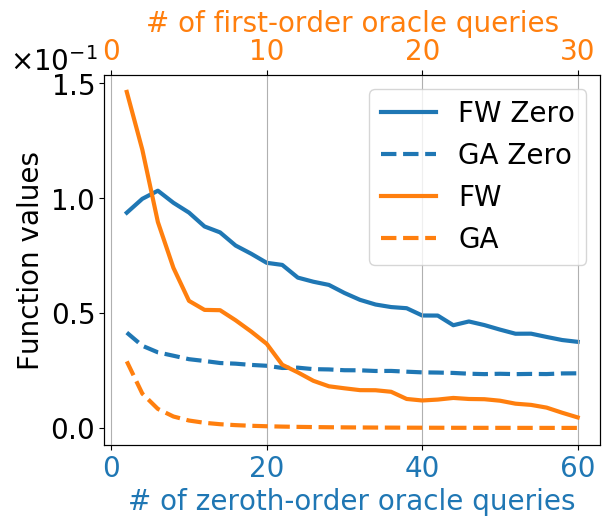

In [97]:
labels = ["FW Zero", "FW", "GA Zero", "GA"]
c0 = "C0"
c1 = "C1"
colors = [c0, c1, c0, c1]
marker = cycle((".", ",", "+", "_", "o", "x", "*"))
get_linestyle = label -> startswith(label, "FW") ? "-" : "--"

# fig, ax1 = subplots()
fig = figure()
ax1 = fig[:add_subplot](111)
ax1[:set_xlabel]("# of zeroth-order oracle queries", color=c0)
ax1[:set_ylabel]("Function values")
ax1[:tick_params](axis="x", labelcolor=c0)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = twiny()  # instantiate a second axes that shares the same x-axis
ax2[:set_xlabel]("# of first-order oracle queries", color=c1)
ax2[:tick_params](axis="x", labelcolor=c1)
# ax2.set_xlabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

fig[:tight_layout]  # otherwise the right y-label is slightly clipped
# plt.show()
for zipped in zip(all_lists, iter_lists, labels)
    reward, iter, label = zipped
    if endswith(label, "Zero")
        ax1[:plot](iter[2:end], reward[2:end], label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c0)
    else
        ax2[:plot](iter[2:end], reward[2:end], label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
#         ax1[:plot](NaN, label=label, linestyle=get_linestyle(label), linewidth=global_width, color=c1)
    end
end

#     save(string(@__DIR__) * "/topic.jld", "topic", all_lists)
fig[:legend](loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1[:transAxes])
ax1[:ticklabel_format](style="sci", axis="y", scilimits=(0, 0), useMathText=true)
# legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1[:transAxes])
# xlabel("Number of oracle queries")
# yscale("log")
# @show keys(ax1[:yaxis])
ax1[:yaxis][:offsetText][:set_position]((-0.19, 0))
ylabel("Function values")
grid()
my_show()
savefig("../pix/regression_function.eps", bbox_inches="tight");

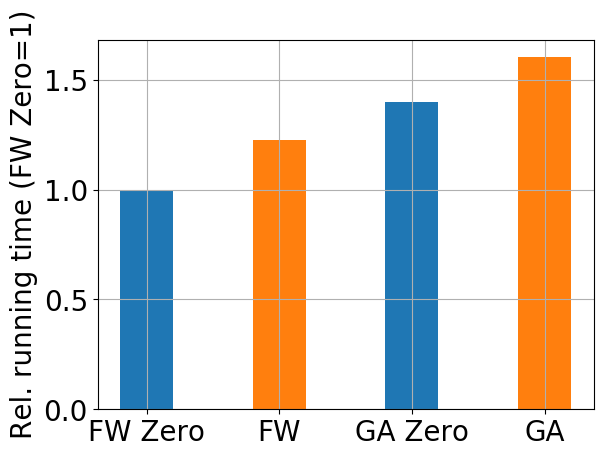

In [184]:
bar(1:4,all_time ./ all_time[1], 0.4, color=colors, tick_label=labels)
grid()
ylabel("Rel. running time (FW Zero=1)");
savefig("../pix/regression_time.eps", bbox_inches="tight");